In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict,StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import RandomForestClassifier
from scipy.stats import f_oneway

In [152]:
df = pd.read_csv('Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [154]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [155]:
miss_value = pd.concat([
    df.isnull().sum(),
    df.count(),
    (df.isnull().sum() * 100 / len(df)).round(2)
],
axis=1,keys=["Missing Values","Present Values","Percent Missing values"]).sort_values(by='Percent Missing values',ascending = False)
miss_value

,Missing Values,Present Values,Percent Missing values
Cabin,687,204,77.10
Age,177,714,19.87
Embarked,2,889,0.22
PassengerId,0,891,0.00
Name,0,891,0.00
Pclass,0,891,0.00
Survived,0,891,0.00
Sex,0,891,0.00
Parch,0,891,0.00
SibSp,0,891,0.00


In [156]:
df = df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)

In [157]:
df = df.drop_duplicates()

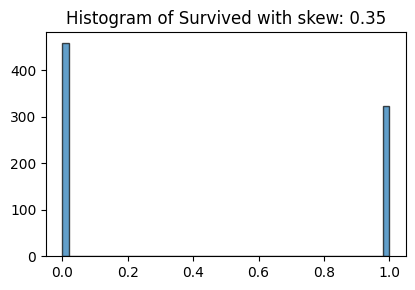

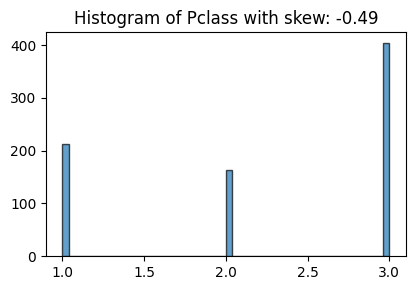

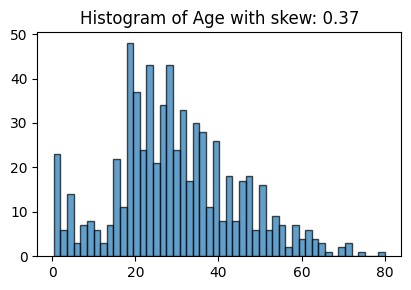

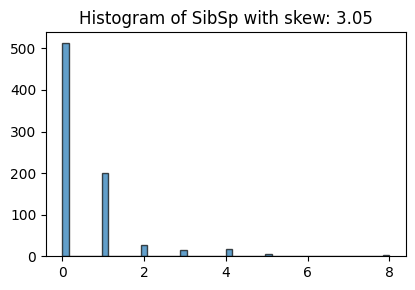

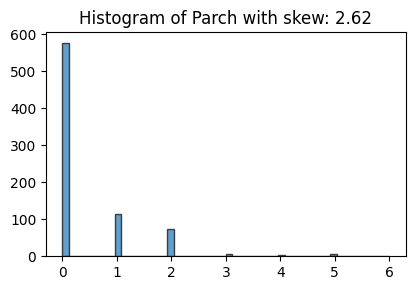

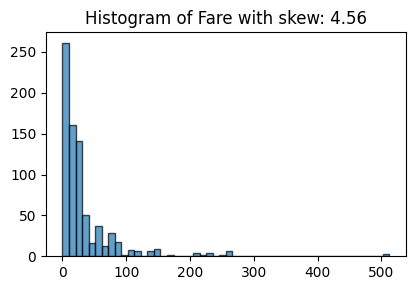

In [158]:
numeric_cols = df.select_dtypes(include='number').columns
for col in numeric_cols:
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    skew_data = df[col].skew()
    plt.hist(df[col], bins=50, edgecolor='black', alpha=0.7)
    plt.title(f"Histogram of {col} with skew: {skew_data:.2f}")
    plt.tight_layout()
    plt.show()

In [159]:
SKEW_THRESHOLD = 1.0

for col in numeric_cols:
    if (df[col] < 0).any():
        continue
    skew = df[col].skew()

    if skew > SKEW_THRESHOLD:
        df[col] = np.log1p(skew)
        n_skew = df[col].skew()

In [160]:
df[numeric_cols].skew()

Survived    0.354825
Pclass     -0.494364
Age         0.366978
SibSp       0.000000
Parch       0.000000
Fare        0.000000
dtype: float64

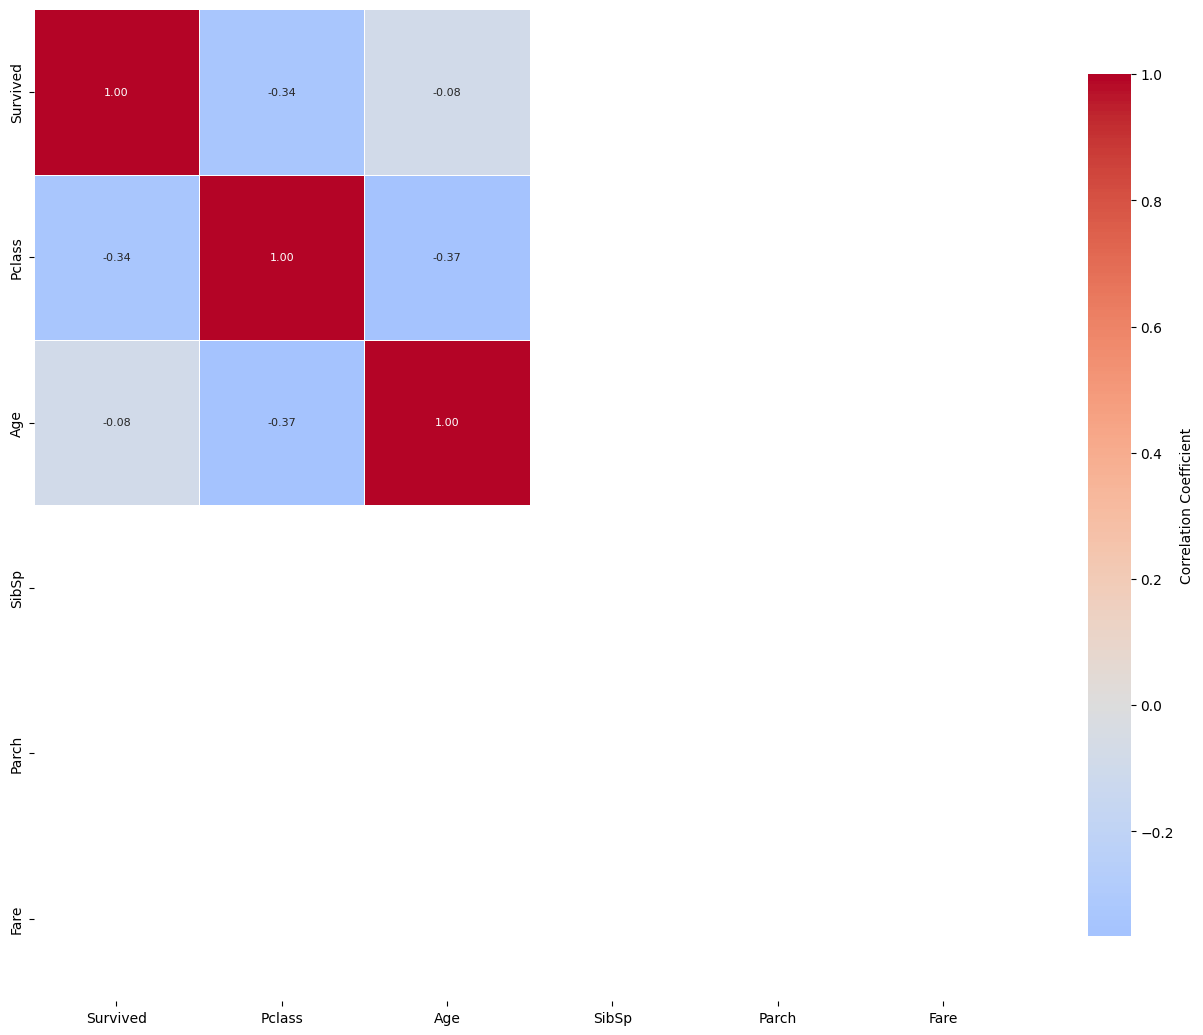

In [161]:
num_corr = df.corr(numeric_only=True)

plt.figure(figsize=(16,14))
sns.heatmap(num_corr, 
            cmap='coolwarm',  
            center=0, 
            annot=True,  
            fmt='.2f', 
            square=True,  
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
            annot_kws={"size": 8}) 
plt.show()

In [162]:
categorical_cols = df.select_dtypes(include = 'object')

IMBALANCED_THRESHOLD = 0.9

imbalanced_list = []

for col in categorical_cols:
    counts = df[col].value_counts(normalize = True)

    max_prop = counts.max()
    if max_prop > IMBALANCED_THRESHOLD:
        imbalanced_list.append(col)

print("\n--- Summary ---")
print("Columns with extreme imbalance (>= 90%):", imbalanced_list)


--- Summary ---
Columns with extreme imbalance (>= 90%): []


In [163]:
MIN_SAMPLES = 5
anova_res = []

for col in categorical_cols:
    if col not in df.columns:
        continue
    counts = df[col].value_counts()
    valid_cats = counts[counts >= MIN_SAMPLES].index
    if len(valid_cats) < 2:
        continue
    groups = [
        df.loc[df[col] == cat, 'Survived'].dropna()
        for cat in valid_cats
    ]
    groups = [g for g in groups if len(g) >= 2]
    if len(groups) < 2:
        continue
    f_stat, _ = f_oneway(*groups)
    anova_res.append({'Feature': col, 'Correlation': f_stat, 'Type': 'Categorical'})

cat_corr_df = pd.DataFrame(anova_res)
cat_corr_df

,Feature,Correlation,Type
0,Sex,278.778562,Categorical
1,Embarked,11.846333,Categorical


In [164]:
X = df.drop('Survived',axis=1)
y = df['Survived']

num_cols = X.select_dtypes(['number']).columns
cat_cols = X.select_dtypes(['object']).columns

num_preprocessor = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

cat_preprocessor = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(drop='first',handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    [
        ('num',num_preprocessor,num_cols),
        ('cat',cat_preprocessor,cat_cols)
    ],
    remainder='drop'
)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

X_train_t = preprocessor.fit_transform(X_train)
X_test_t = preprocessor.transform(X_test)

In [177]:
model = LogisticRegression()

model.fit(X_train_t,y_train)

test_score = model.score(X_test_t,y_test)
train_score = model.score(X_train_t, y_train)

print(f"Train Accuracy: {train_score:.3f}")
print(f"Test Accuracy: {test_score:.3f}")

Train Accuracy: 0.767
Test Accuracy: 0.791
